In [46]:
from qreservoirpy import util
from qreservoirpy.reservoirs import Static

from qiskit.quantum_info import Clifford, random_clifford
from qiskit.extensions import HamiltonianGate
from qiskit.circuit.library import PauliGate
from qiskit.circuit.library import U1Gate

In [47]:
import numpy as np


class Stabilizer(Static):
    def __init__(self, n_qubits, n_ancilla, encoder, memory=np.inf, backend=None) -> None:
        super().__init__(n_qubits + 1, memory, backend)
        self.n_logical = n_qubits
        self.n_ancilla = n_ancilla
        self.encoder = encoder

        OP = random_clifford(n_qubits)
        self.reservoir = OP
        # H = util.random_ising_H(num_qubits=n_qubits, num_terms=40)
        # T = 1 #s
        # self.reservoir = HamiltonianGate(H, T, label="UT")
            
        cliff = Clifford(OP)
        ops = [elem[-self.n_logical:] for elem in cliff.stabilizer.to_labels()]
        self.ops = [PauliGate(elem).control(1) for elem in ops]

    def before(self, circuit):
        return super().before(circuit)
    def during(self, circuit, timestep):
        circuit.barrier()

        for i in range(self.n_ancilla):
            anc = self.n_logical
            circuit.initialize('0', anc)
            circuit.cx(i, anc)
            # circuit.append(self.ops[i], [anc] + list(np.arange(self.n_logical)))
            # circuit.h(anc)
            circuit.measure(anc)
        
            circuit.append(self.encoder[timestep], [i])
        circuit.append(self.reservoir, range(self.n_logical))
    def after(self, circuit):
        return super().after(circuit)
    


In [48]:
encoder = {}
timestep = [0, 1, 2, 3]
timeseries = timestep * 10
SHOTS = 10000
n_qubits = 4
n_ancilla = 3
N = np.unique(timestep).size
epsilon = np.random.random()
for idx, elem in enumerate(np.unique(timestep)):
    theta = idx * 2 * np.pi / N + epsilon
    encoder[elem] = U1Gate(theta, str(elem))

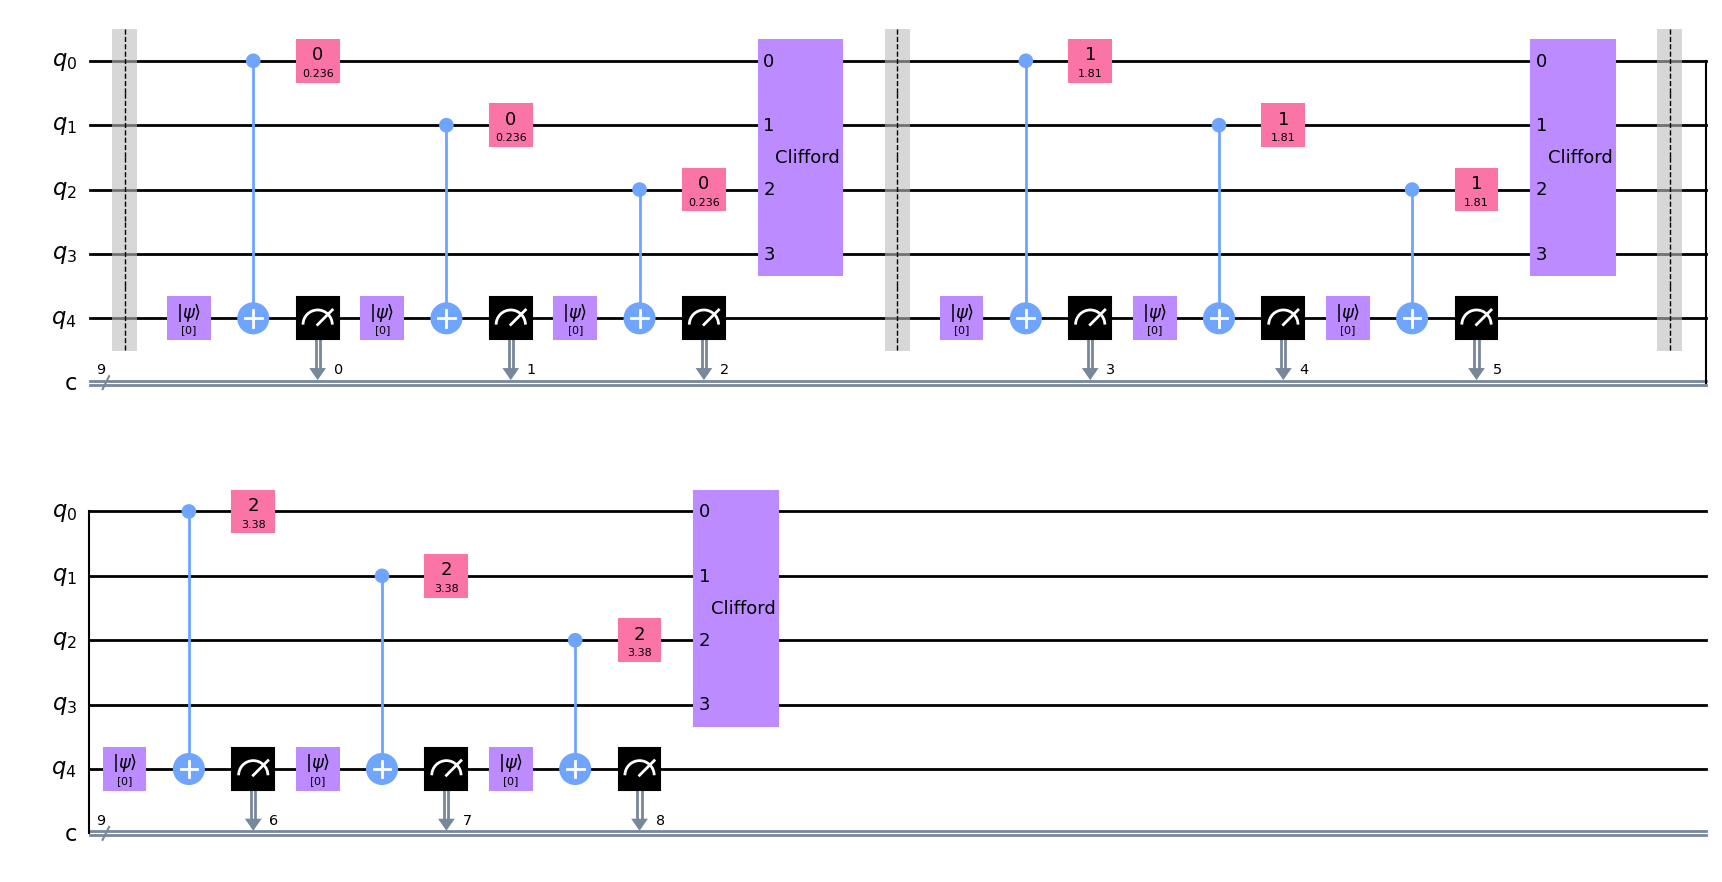

In [49]:

qres = Stabilizer(
    n_qubits=n_qubits,
    n_ancilla=n_ancilla,
    encoder=encoder
)

qres.circuit([0, 1, 2], merge_registers=True, transpile=False).draw('mpl')

In [50]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS,
)

In [51]:

WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]


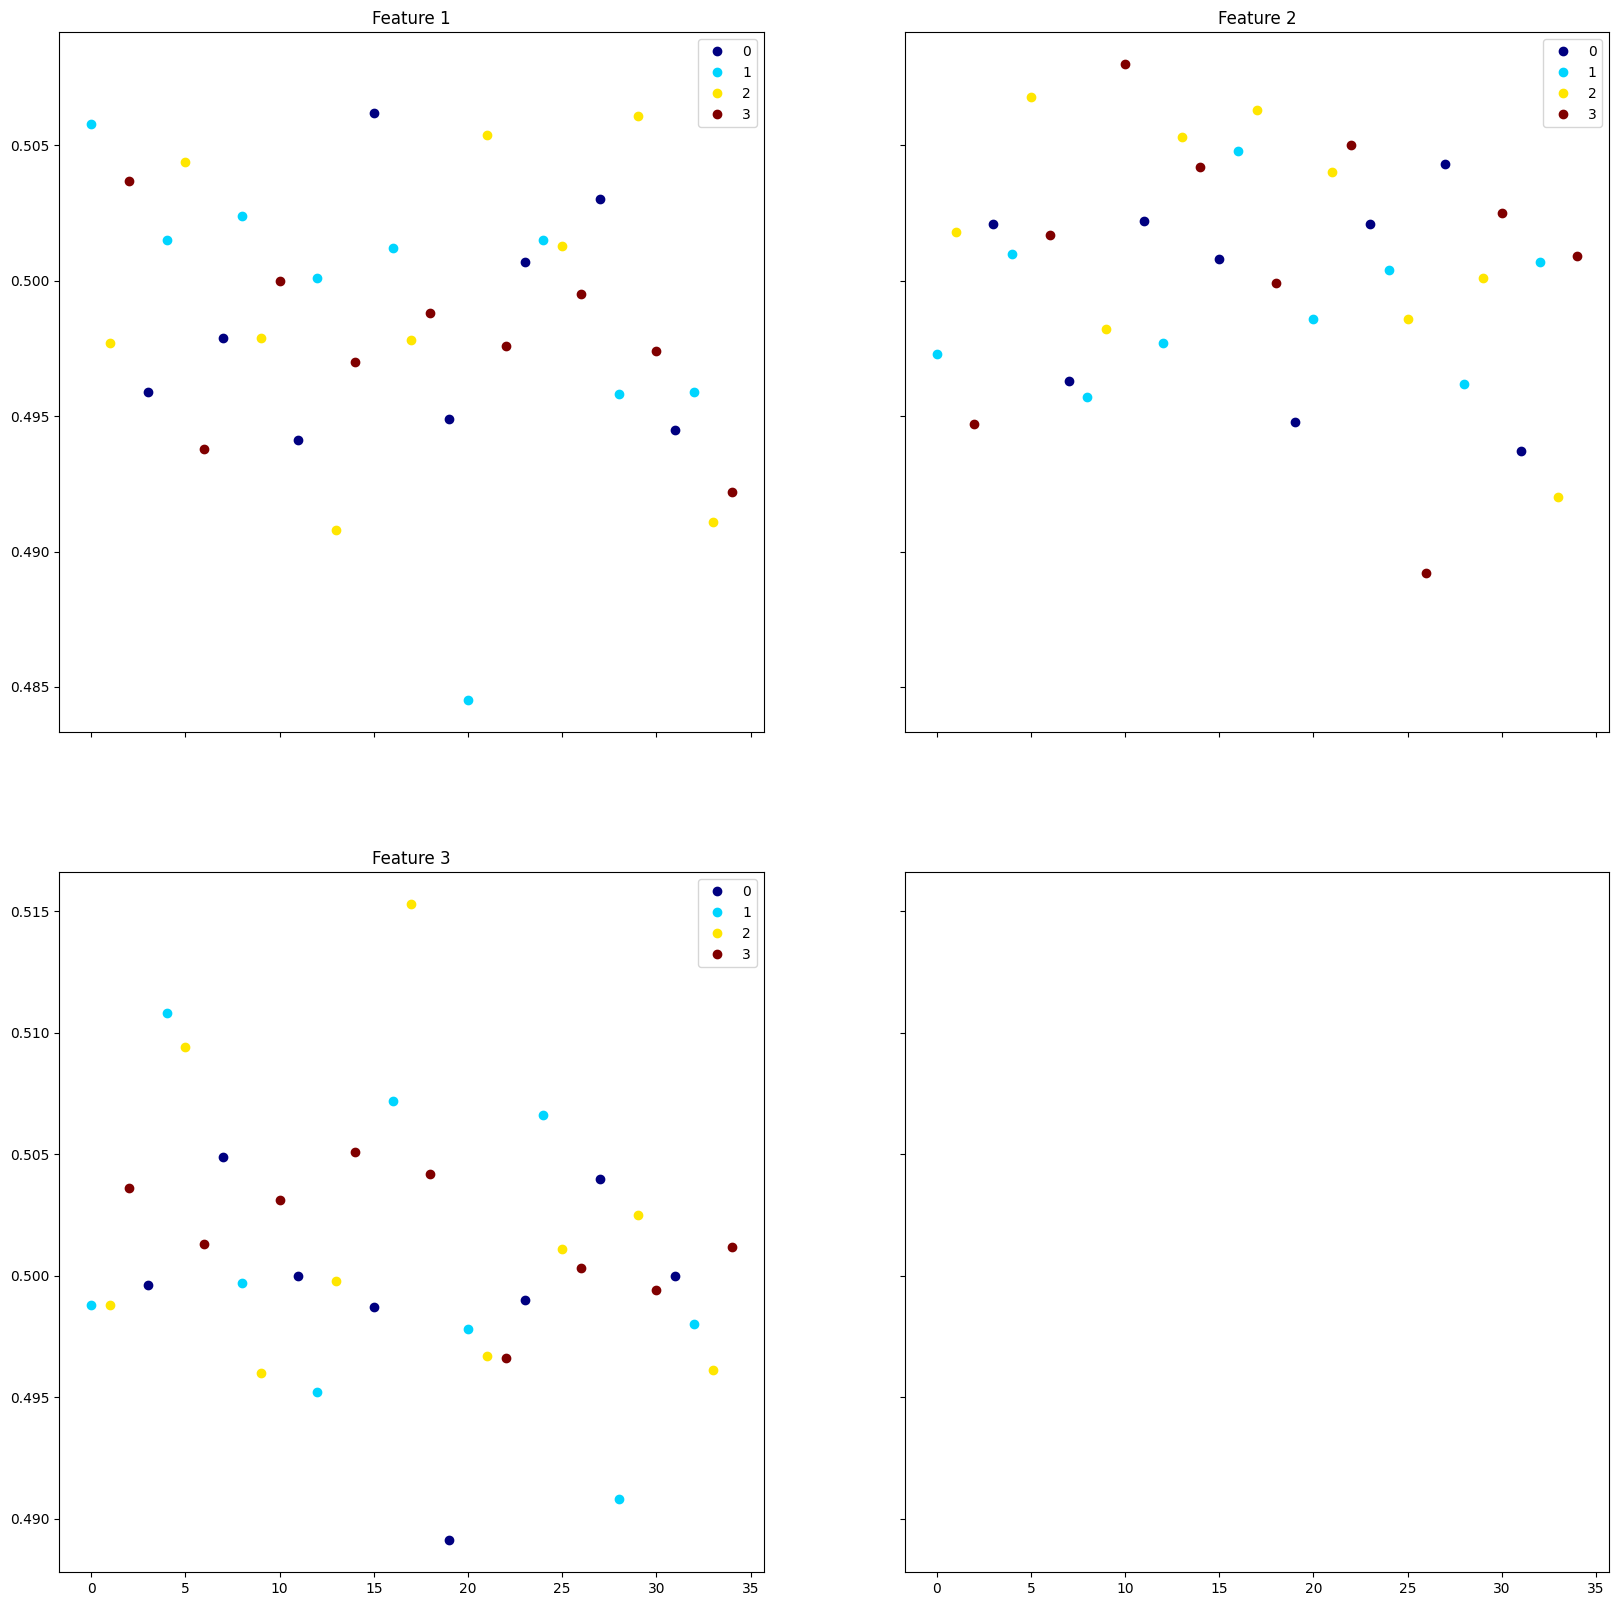

In [52]:
from qreservoirpy.plot import state_plotter
fig, ax = state_plotter(xstates, target)

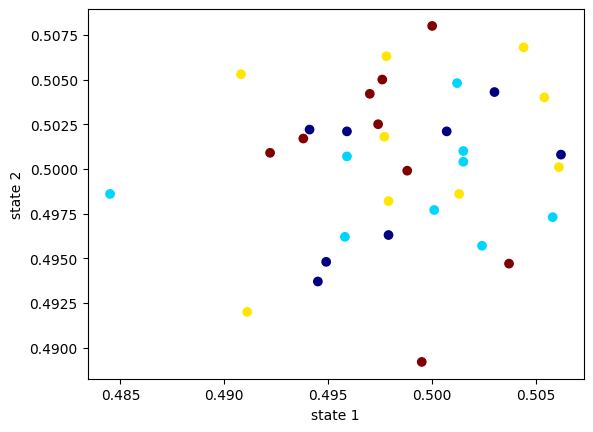

In [53]:
from qreservoirpy.plot import feature_plotter
fig, ax = feature_plotter(xstates, target)


In [54]:
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = np.array([
    SVC(kernel=ker, max_iter=1000) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] 
+ [
    RidgeClassifier(alpha=alph, max_iter=1000) for alph in np.linspace(0, 1e-3, 9)
] 
+ [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
]
, dtype=object)

In [55]:
import warnings
warnings.filterwarnings('ignore')

results = util.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of KNeighborsClassifier(n_neighbors=2): 0.21916666666666668
Score of SVC(kernel='poly', max_iter=1000): 0.21750000000000003
Score of KNeighborsClassifier(n_neighbors=3): 0.21249999999999997
Score of KNeighborsClassifier(n_neighbors=4): 0.19833333333333325
Score of KNeighborsClassifier(n_neighbors=6): 0.19333333333333325
Score of KNeighborsClassifier(): 0.18999999999999992
Score of KNeighborsClassifier(n_neighbors=7): 0.18833333333333332
Score of SVC(max_iter=1000): 0.1825
Score of KNeighborsClassifier(n_neighbors=8): 0.1725
Score of KNeighborsClassifier(n_neighbors=1): 0.16833333333333336
Score of KNeighborsClassifier(n_neighbors=9): 0.16749999999999995
Score of SVC(kernel='sigmoid', max_iter=1000): 0.1483333333333333
Score of SVC(kernel='linear', max_iter=1000): 0.13249999999999998
Score of RidgeClassifier(alpha=0.0, max_iter=1000): 0.13083333333333338
Score of RidgeClassifier(alpha=0.000125, max_iter=1000): 0.12416666666666668
Score of RidgeClassifier(alpha=0.000375, max_iter=1

In [56]:
predict_from = timestep
num_preds = 10


preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


Predicting...: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


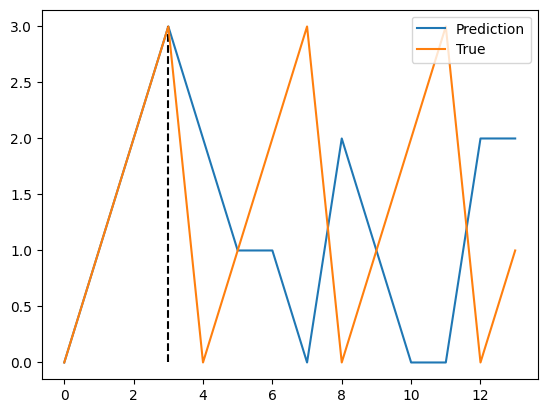

In [57]:
import matplotlib.pyplot as plt
pred_plot = np.append(predict_from, preds)
true_plot = np.append(predict_from, timeseries[:len(pred_plot) - len(predict_from)])
plt.plot(pred_plot, label="Prediction")
plt.vlines(len(predict_from)-1, ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')

plt.plot(true_plot, label="True")
plt.legend()
